## Exploratory Data Analysis - Team 8

### 1. General EDA

#### 1.1 Load Dataset - Data cleansing

#### 1.2 Univariate Analysis

* New users (registrations completed) evolution.
* Sign-in (app usage) evolution.
* Cash-in and Cash-out transactions evolution.
* Support tickets and sign-in evolution.
* Demographic features (global numbers: age, sex, province, etc)

#### 1.3 Multivariate Analysis

* Correlation Matrix (Pearson). 
* Variables relationship analysis before studying Association Rules.

### 2. EDA - Association Rules

* Total products.
* Most frequent items/itemsets.
* Most frequent rules.
* Business rules.



Importing packages and libraries...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import boto3
from datetime import datetime, timedelta
import awswrangler as wr
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
sns.set(style="whitegrid")
paleta_uala = ['#3E6BFD','#698cff','#9eb5ff','#d5dfff','#3E6BFD']
import pingouin as pg 
import scipy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="example")
import folium 

# 1. General EDA

## 1.1 Load Dataset - Data cleansing

The parquet file where data is stored is loaded from an Amazon S3 bucket:

In [73]:
df = wr.s3.read_parquet(f's3://test-uala-arg-datalake-aiml-recommendations/data/stage/all_data_v2/')
df.rename(columns={"nu_sin_categoria_aprob":"nu_compras_otras_categorias_aprob"}, inplace=True)

In [3]:
df.shape

(8018032, 111)

Fetuares with NULL values are checked.

In [5]:
df.isnull().sum()

year_month                                      0
os_name                                         0
cobros                                    3804298
cuotificaciones                            986498
inversiones                                     0
pago_servicios                                  0
prestamos                                       0
promociones                               3804298
recargas                                        0
transferencia_c2c                          418894
transferencia_cvu                          418894
account_id                                      0
external_id                                     0
vl_cashin_efectivo_sum                          0
vl_cashin_inversiones_sum                       0
vl_cashin_transferencia_sum                     0
vl_cashin_prestamos_sum                         0
vl_cashin_c2c_sum                               0
vl_cashin_adquirencia_sum                       0
vl_cashin_ajustes_sum                           0


As features containing null values are representing null transactionality, it is correct to fill them with 0.

In [74]:
df[['cobros','cuotificaciones','promociones','transferencia_c2c','transferencia_cvu']] = df[['cobros','cuotificaciones','promociones','transferencia_c2c','transferencia_cvu']].fillna(0)

In [75]:
df = df.dropna()

The data type for the variable "dt" is modified and the name is changed.

In [76]:
df['dt'] = pd.to_datetime(df['dt'])

In [77]:
df = df.rename({'dt':'periodo'}, axis=1)

The variable user account age is created:

In [78]:
# Last timeframe available
max_periodo = df.periodo.max()
max_periodo = pd.to_datetime(max_periodo)

In [79]:
df.fecha_alta = pd.to_datetime(df.fecha_alta)
df.fecha_alta = np.where(df.fecha_alta > max_periodo , max_periodo, df.fecha_alta.dt.date)

In [80]:
df['antiguedad']= max_periodo - df.fecha_alta

In [81]:
df['antiguedad'] = df['antiguedad'].dt.days

## 1.2 Univariate Analysis

### New users (registrations completed) evolution.

In [14]:
temp = df.copy()
temp['periodo_alta'] = pd.to_datetime(df['fecha_alta'], format='%Y/%m').dt.strftime('%Y-%m')

temp = (temp
 .groupby("periodo_alta")
 .account_id
 .agg('count')
)


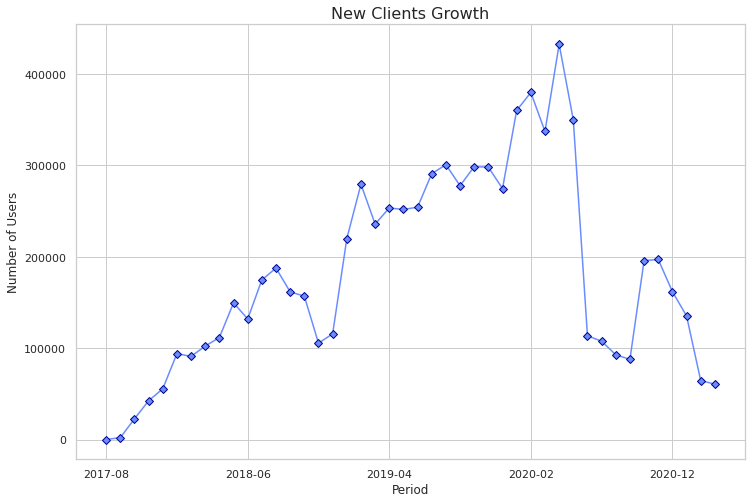

In [15]:
ax = temp.plot(figsize=(12,8), color='#698cff',marker='D', markeredgecolor='darkblue')
ax.set_xlabel("Period")
ax.set_ylabel("Number of Users")
_ = ax.set_title("New Clients Growth", fontsize=16)

### Sign-in (app usage) evolution.

In [12]:
temp = (df
 .groupby("periodo")
 .account_id
 .agg('count')
)

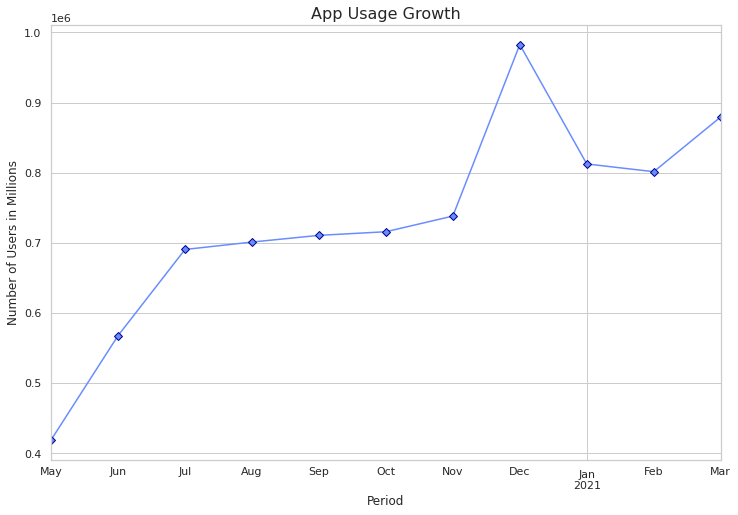

In [13]:
ax = temp.plot(figsize=(12,8), color='#698cff',marker='D', markeredgecolor='darkblue')
ax.set_xlabel("Period")
ax.set_ylabel("Number of Users in Millions")
_ = ax.set_title("App Usage Growth", fontsize=16)

From the above charts we can observe that, although the number of user registrations decreased during the pandemic, the app usage trend continues to grow.

## Cash-in and Cash-out transactions evolution.

### Cashout transactions average values

In [21]:
temp = (df
 .groupby("periodo", as_index = False)['vl_compras_aprob',
                        'vl_withdraw_atm_aprob',
                        'vl_investments_deposit_aprob',
                        'vl_telerecargas_carga_aprob',
                        'vl_user_to_user_aprob', 
                        'vl_cash_out_cvu_aprob'
                       ]
 .agg('mean')
).rename(columns={"periodo":"period"})

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [22]:
temp_pivot = temp.melt(var_name = "cashout",
                     value_name = "Media_usd",
                     id_vars = ["period"],
                     value_vars = ['vl_compras_aprob',
                        'vl_withdraw_atm_aprob',
                        'vl_investments_deposit_aprob',
                        'vl_telerecargas_carga_aprob',
                        'vl_user_to_user_aprob', 
                        'vl_cash_out_cvu_aprob']) 

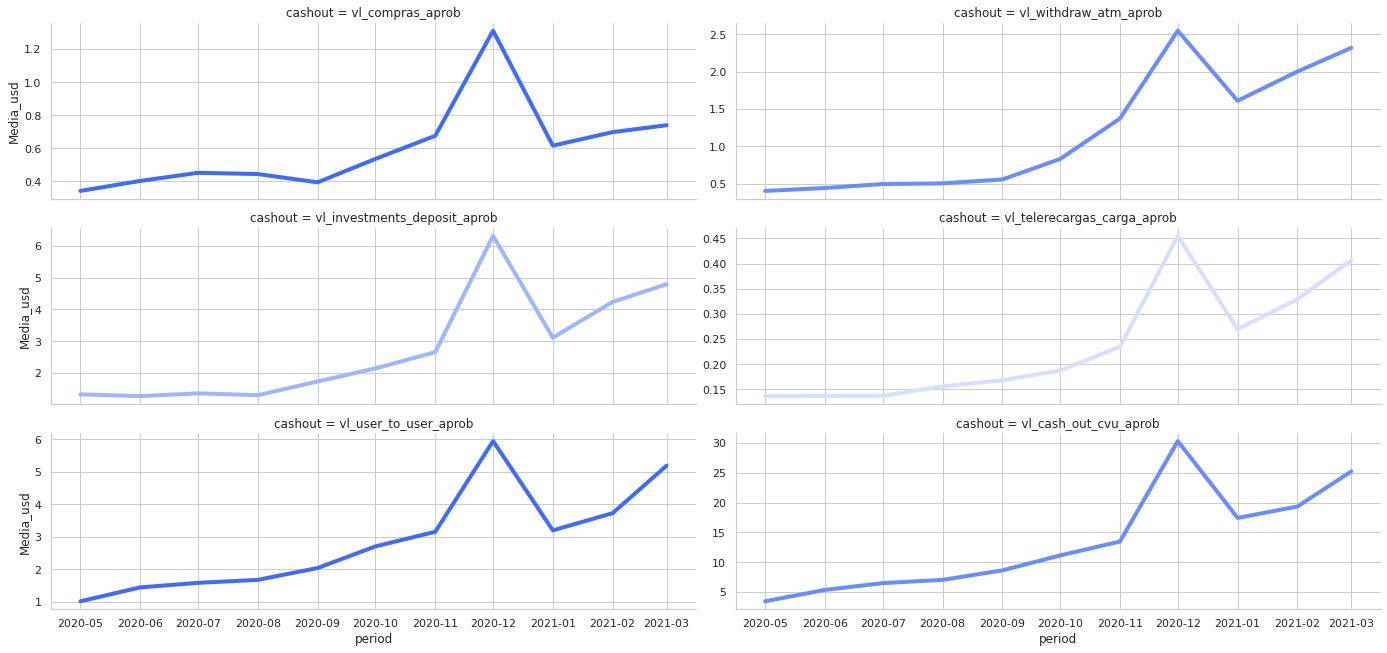

In [23]:
g = sns.relplot(
    data = temp_pivot,
    x="period", y="Media_usd", col="cashout", hue="cashout",
    kind="line", palette= ['#3E6BFD','#698cff','#9eb5ff','#d5dfff','#3E6BFD','#698cff'], linewidth=4, zorder=5,
    col_wrap=2, height=3, aspect=3.2, legend=False, facet_kws=dict(sharey=False)
)


It is observed in the cashout (USD average amoutns) plot that there is a positive trend with a peak in December, although it presents different levels depending on the product used.

### Cashin transactions average values

In [24]:
temp = (df
 .groupby("periodo", as_index = False)['vl_cashin_efectivo_sum',
                                       'vl_cashin_transferencia_sum']
 .agg('mean')
).rename(columns={"periodo":"period"})

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


In [25]:
temp_pivot = temp.melt(var_name = "cashin",
                     value_name = "Media_usd",
                     id_vars = ["period"],
                     value_vars = ['vl_cashin_efectivo_sum',
                                  'vl_cashin_transferencia_sum'])

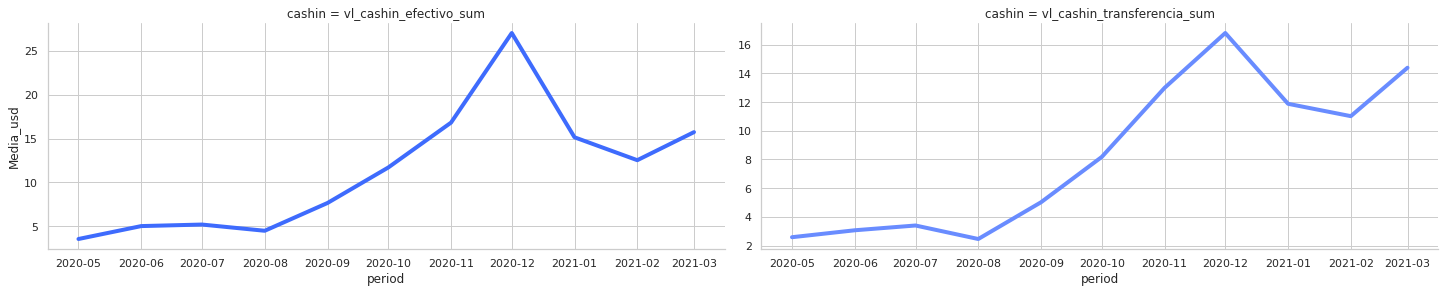

In [26]:
g = sns.relplot(
    data = temp_pivot,
    x="period", y="Media_usd", col="cashin", hue="cashin",
    kind="line", palette=['#3E6BFD','#698cff'], linewidth=4, zorder=5,
    col_wrap=2, height=4, aspect=2.5, legend=False, facet_kws=dict(sharey=False)
)

It is observed in the cashin (USD average amounts) plot that there is a positive trend with a peak in December. Cash transactions has more abrupt rises and falls respect to bank-transfers.

## Support tickets and sign-in evolution

In [27]:
temp = (df
 .groupby("periodo", as_index = False)['nu_incidente',
                                       'nu_inicio',
                                       'nu_bloqueo']
 .agg('mean')
 .fillna(0)
).rename(columns={"periodo":"period"})

temp_pivot = temp.melt(var_name = "evento",
                       value_name = "cantidad_media",
                       id_vars = ["period"],
                       value_vars = ['nu_incidente',
                                     'nu_inicio',
                                    'nu_bloqueo'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


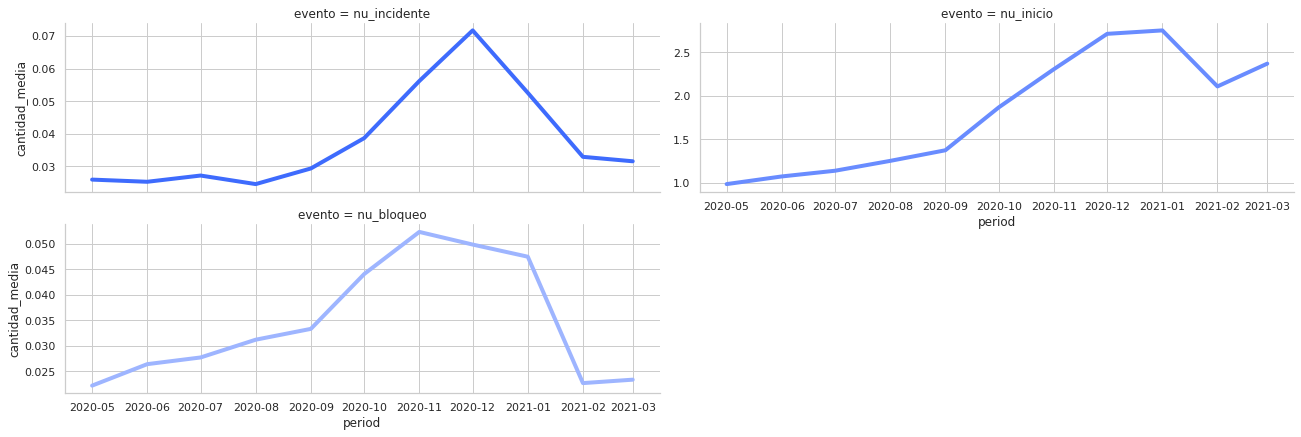

In [28]:
g = sns.relplot(
    data = temp_pivot,
    x="period", y="cantidad_media", col="evento", hue="evento",
    kind="line", palette= ['#3E6BFD','#698cff','#9eb5ff'], linewidth=4, zorder=5,
    col_wrap=2, height=3, aspect=3.0, legend=False, facet_kws=dict(sharey=False)
)

## Demographic features (global numbers: age, sex, province, etc)

**User account age**

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


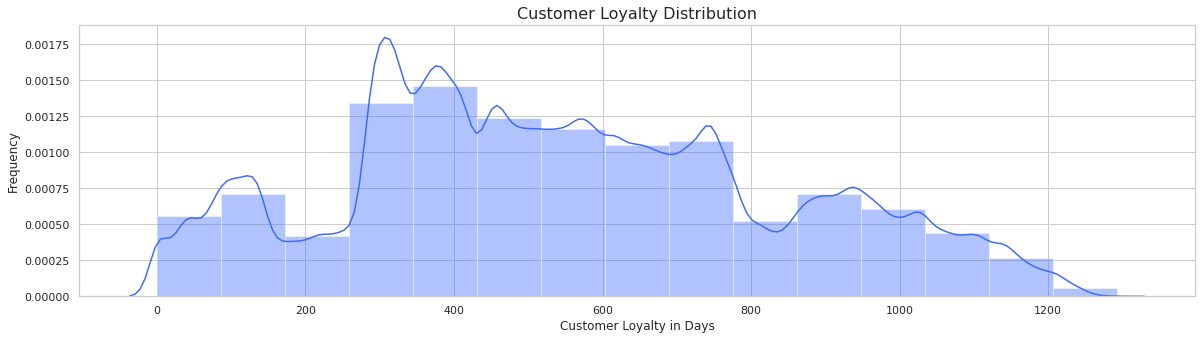

In [29]:
plt.figure(figsize=(20,5))

sns.distplot(df.antiguedad, kde=True, hist=True, bins=15, color='#3E6BFD')
plt.xlabel('Customer Loyalty in Days')
plt.ylabel('Frequency')
plt.title('Customer Loyalty Distribution', fontsize=16)
plt.show()

Observing the user account age (Customer loyalty) distribution we can confirm that the number of new users has been decreasing, reaching minimum value in March 2020 coinciding with the start of the pandemic in Argentina.

**Customer's Age**

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


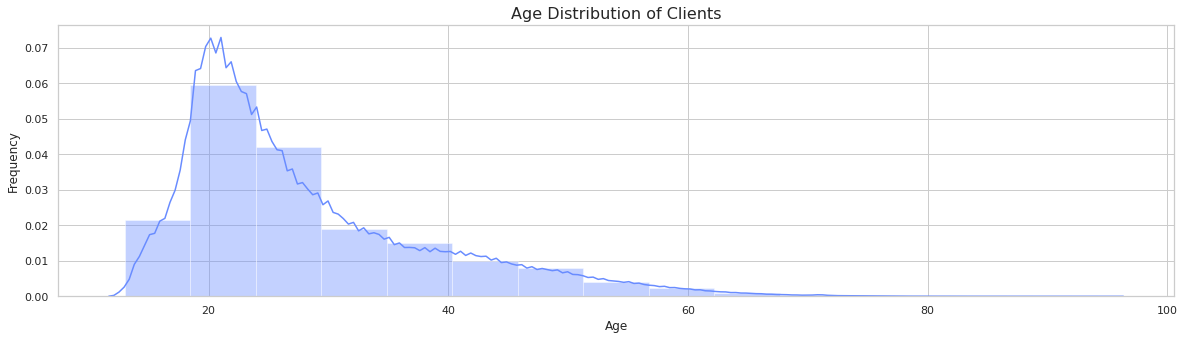

In [82]:
df['fecha_nacimiento'] = pd.to_datetime(df['fecha_nacimiento'], format='%Y/%m/%d')
df['edad']=[math.trunc((datetime.now()-i).days/365)  for i in df['fecha_nacimiento']]
plt.figure(figsize=(20,5))

sns.distplot(df.edad, kde=True, hist=True, bins=15, color='#698cff')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Clients', fontsize=16)

plt.show()

The age distribution is skewed to the right, concentrating the user base in the age range from 18 to 30 years.

**Areas where users reside**

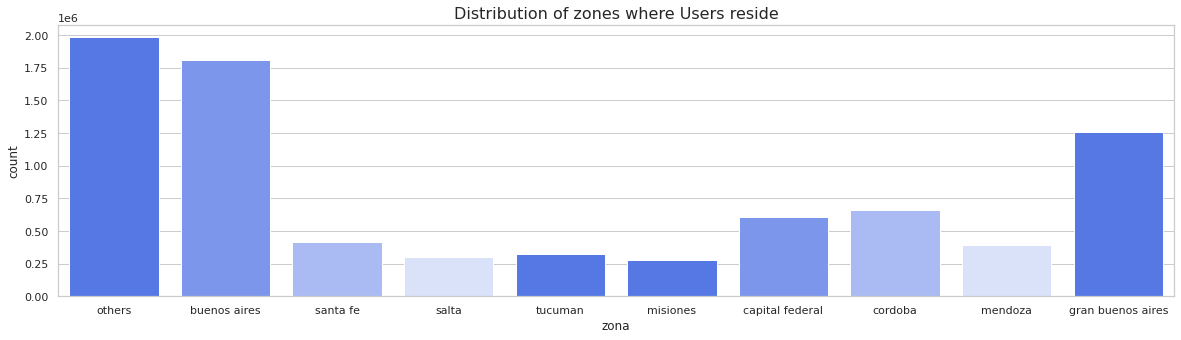

In [83]:
df['zona']=df.provincia.str.lower()
df.loc[-df.provincia.isin(['santa fe','cordoba','buenos aires','capital federal',
                                                            'gran buenos aires','mendoza','tucuman','salta',
                                                           'misiones']),\
                         'zona']='others'
plt.figure(figsize=(20,5))
sns.countplot(x=df.zona, palette=paleta_uala)
plt.title('Distribution of zones where Users reside', fontsize=16)

plt.show()

This plot shows the most populated areas in Argentina versus the rest. Within it, it can be observed that the distribution of Ualá users is concentrated in the province of Buenos Aires and the category 'Others' presents a high density since it summarizes the number of users of the rest of the country's provinces.

#### Unique Clients 's Location Map

In [218]:
provincias=pd.DataFrame(df.groupby('provincia')['account_id'].nunique()).reset_index(False)
provincias['provincia']=provincias['provincia']+', Argentina'

In [219]:
#Para mejorar la visibilad de puntos muy cercados muevo las coordenadas
provincias['provincia_coord_names']=np.where(provincias['provincia'].str.strip()=='buenos aires, Argentina','tandil,buenos aires',provincias['provincia'])
provincias['provincia_coord_names']=np.where(provincias['provincia_coord_names'].str.strip()=='gran buenos aires, Argentina','la matanza,buenos aires',provincias['provincia_coord_names'])

In [220]:
l['COORDS'] = []
for k in provincias.provincia_coord_names.unique():
    loc = geolocator.geocode(k).raw
    l['COORDS'].append((loc['lat'], loc['lon']))
provincias['COOR']=l['COORDS']

In [229]:
mapita = folium.Map(location=[-38,-64], zoom_start=3.5)

provincias['label']=provincias['provincia']+', Unique Users:'+provincias['account_id'].astype(str)

for i,r in provincias.iterrows():
   folium.Circle(
      location=r['COOR'],
      popup=r['label'],
      radius=r['account_id']/2,
      color='#69b3a2',
      fill=True,
      fill_color='#69b3a2'
   ).add_to(mapita)
mapita


## Carrier and User Operating System

**Carriers**

In [47]:
temp = df.copy()

condlist=[
    temp.fl_carrier_claro == 1,
    temp.fl_carrier_movistar == 1,
    temp.fl_carrier_personal == 1,
    temp.fl_carrier_tuenti ==1
    
]

choicelist=['Claro','Movistar','Personal','Tuenti']
temp['cd_empresa_tel']=np.select(condlist,choicelist)
temp['cd_empresa_tel']=(np.where(temp['cd_empresa_tel']=='0','otros',temp['cd_empresa_tel']))

In [48]:
b = temp.groupby(['periodo','cd_empresa_tel']).account_id.count().reset_index(name='cantidad_clientes')
b = b[b.cd_empresa_tel != 'otros']
b['periodo']= b['periodo'].dt.date

In [49]:
b.rename(columns={"cd_empresa_tel":"phone_company"},inplace=True)
b_pivot = pd.pivot_table(
    b, 
    values="cantidad_clientes",
    index="periodo",
    columns="phone_company", 
    aggfunc='sum'
)

Text(0, 0.5, 'Number of Clients')

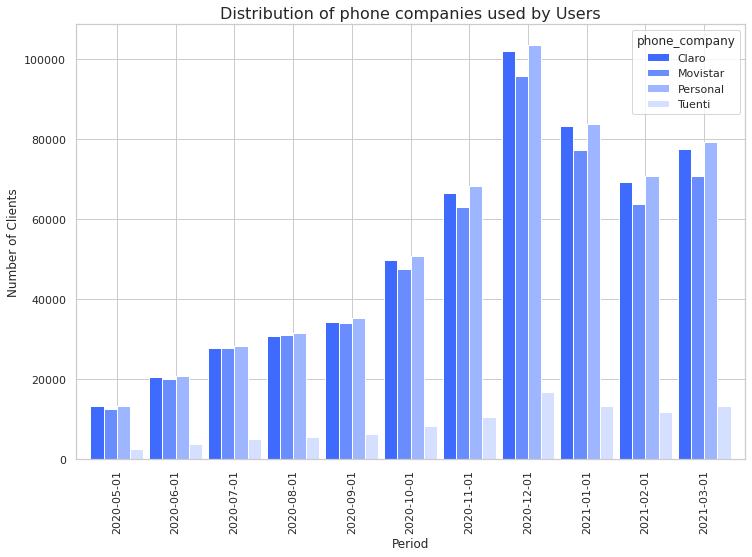

In [52]:
ax = b_pivot.plot(kind="bar", color= paleta_uala, width=0.9)
fig = ax.get_figure()
fig.set_size_inches(12, 8)

plt.title('Distribution of phone companies used by Users', fontsize=16)
ax.set_xlabel("Period")
ax.set_ylabel("Number of Clients")

This chart represents which telephone company users have. It is well distributed between three companies: Personal, Claro and Movistar.

**Operating System**

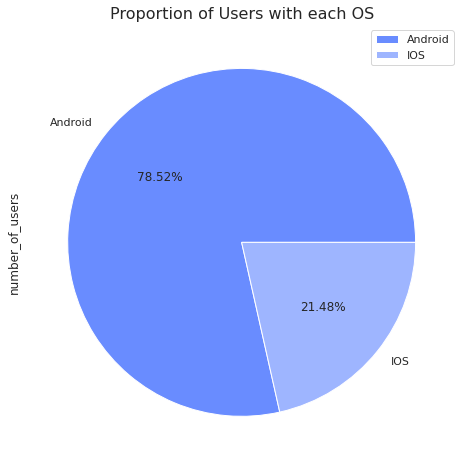

In [54]:
temp["Android_OS"] = np.where(temp.fl_os_android==0,'Android','IOS')
temp_pie = temp.groupby(["Android_OS"])["account_id"].count().reset_index(name="number_of_users")

ax = temp_pie.plot.pie(y="number_of_users", labels=temp_pie.Android_OS, autopct="%1.2f%%", figsize=(10, 8), colors=['#698cff','#9eb5ff'])
_ = ax.set_title("Proportion of Users with each OS", fontsize=16)

This plot exposes that most users have Android cellphones.

## 1.3 Multivariate Analysis

### Correlation Matrix

A Pearson correlation matrix was made to evaluate the linear correlation between variables, and visualize the most interesting ones for our analysis.

In [ ]:
# We select the variables that we do not want to have within the correlation matrix
a = df.columns.isin(['account_id','year_month','os_name','external_id','periodo','fecha_alta','provincia','sexo','fecha_nacimiento','zona'])
a_comple = df.columns[~a]

# We create a new df without the variables we choose
df_ = df.loc[:,a_comple]

For this analysis, the strongest linear correlations were ruled out, that is, greater than 90% and less than 0.5%, to simplify the bivariate analysis considering the large number of variables the dataset has.

In [44]:
# Correlation matrix (absolute values)
temp = df_.copy()
corr_matrix = temp.corr().abs()

# We select upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# We remove variables with correlations greater than 90% and less than 0.5%.
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop2 = [column for column in upper.columns if any(upper[column] < 0.005)]

# We delete those lists
temp.drop(to_drop+to_drop2, axis=1, inplace=True)

temp.shape

(8018021, 13)

In [40]:
# Correlation Matrix
matriz = temp.corr()
matriz.style.background_gradient(cmap='coolwarm')

,cobros,cuotificaciones,inversiones,prestamos,promociones,transferencia_c2c,transferencia_cvu,nu_cashin_inversiones_qty,nu_tcc_r_aprob,nu_consumption_pos_aprob,nu_compras_otras_categorias_aprob,nu_incidente,nu_inicio
cobros,1.000000,0.022466,0.047572,0.022941,0.089574,0.045485,0.044420,0.028039,0.013904,0.014150,0.019717,0.031128,0.026560
cuotificaciones,0.022466,1.000000,0.013221,0.029385,0.008980,0.011527,0.010000,0.007659,0.006897,0.012085,0.006433,0.010313,0.009066
inversiones,0.047572,0.013221,1.000000,0.022951,0.053420,0.148038,0.132502,0.330015,0.040906,0.040598,0.106087,0.044557,0.135199
prestamos,0.022941,0.029385,0.022951,1.000000,0.020614,0.012432,0.011303,0.011861,0.006740,0.005270,0.007457,0.020107,0.014396
promociones,0.089574,0.008980,0.053420,0.020614,1.000000,0.049659,0.037611,0.033908,0.025552,0.019568,0.025180,0.066610,0.091924
transferencia_c2c,0.045485,0.011527,0.148038,0.012432,0.049659,1.000000,0.871094,0.103954,0.069065,0.073915,0.510347,0.125159,0.196855
transferencia_cvu,0.044420,0.010000,0.132502,0.011303,0.037611,0.871094,1.000000,0.098753,0.059242,0.053371,0.507845,0.107673,0.163021
nu_cashin_inversiones_qty,0.028039,0.007659,0.330015,0.011861,0.033908,0.103954,0.098753,1.000000,0.199037,0.202746,0.320888,0.141081,0.373914
nu_tcc_r_aprob,0.013904,0.006897,0.040906,0.006740,0.025552,0.069065,0.059242,0.199037,1.000000,0.542407,0.196971,0.130421,0.403821
nu_consumption_pos_aprob,0.014150,0.012085,0.040598,0.005270,0.019568,0.073915,0.053371,0.202746,0.542407,1.000000,0.364330,0.144278,0.397430


**Heatmaps**

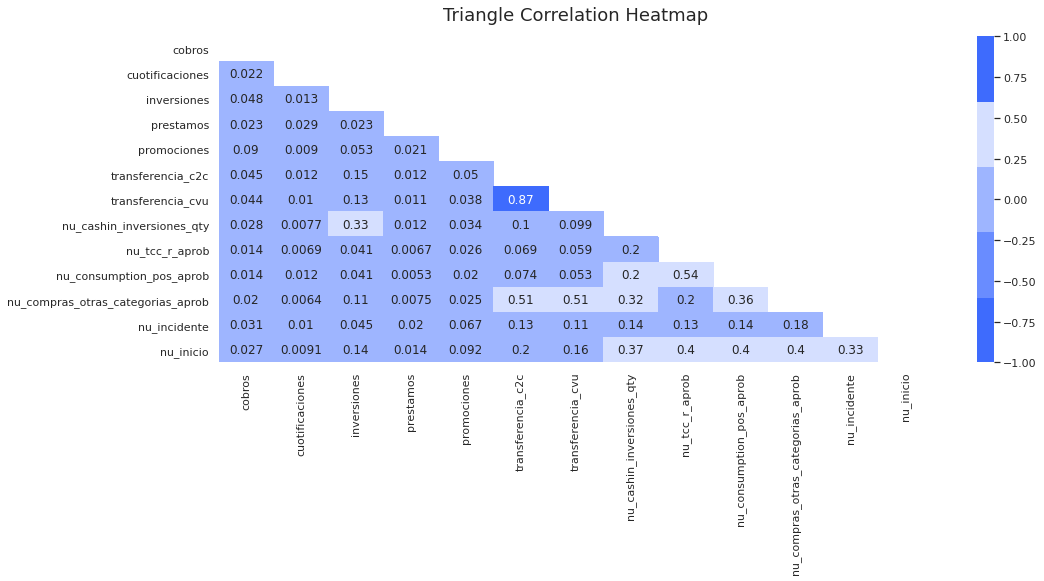

In [41]:
plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(matriz, dtype=np.bool))
heatmap = sns.heatmap(matriz, mask=mask, vmin=-1, vmax=1, annot=True, cmap=paleta_uala)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

From the previous heatmap, the following correlations stand out:

* inversiones -> transferencia_cvu
* transferencia_c2c -> nu_compras_otras_categorias_aprob
* nu_cashin_inversiones_qty -> nu_consumption_pos_aprob
* nu_tcc_r_aprob -> nu_incidente
* nu_inicio -> transferencia_cvu, nu_cashin_inversiones_qty, nu_tcc_r_aprob, nu_consumption_pos_aprob, 
* nu_compras_otras_categorias_aprob, nu_incidente

## Bivariate Relationships

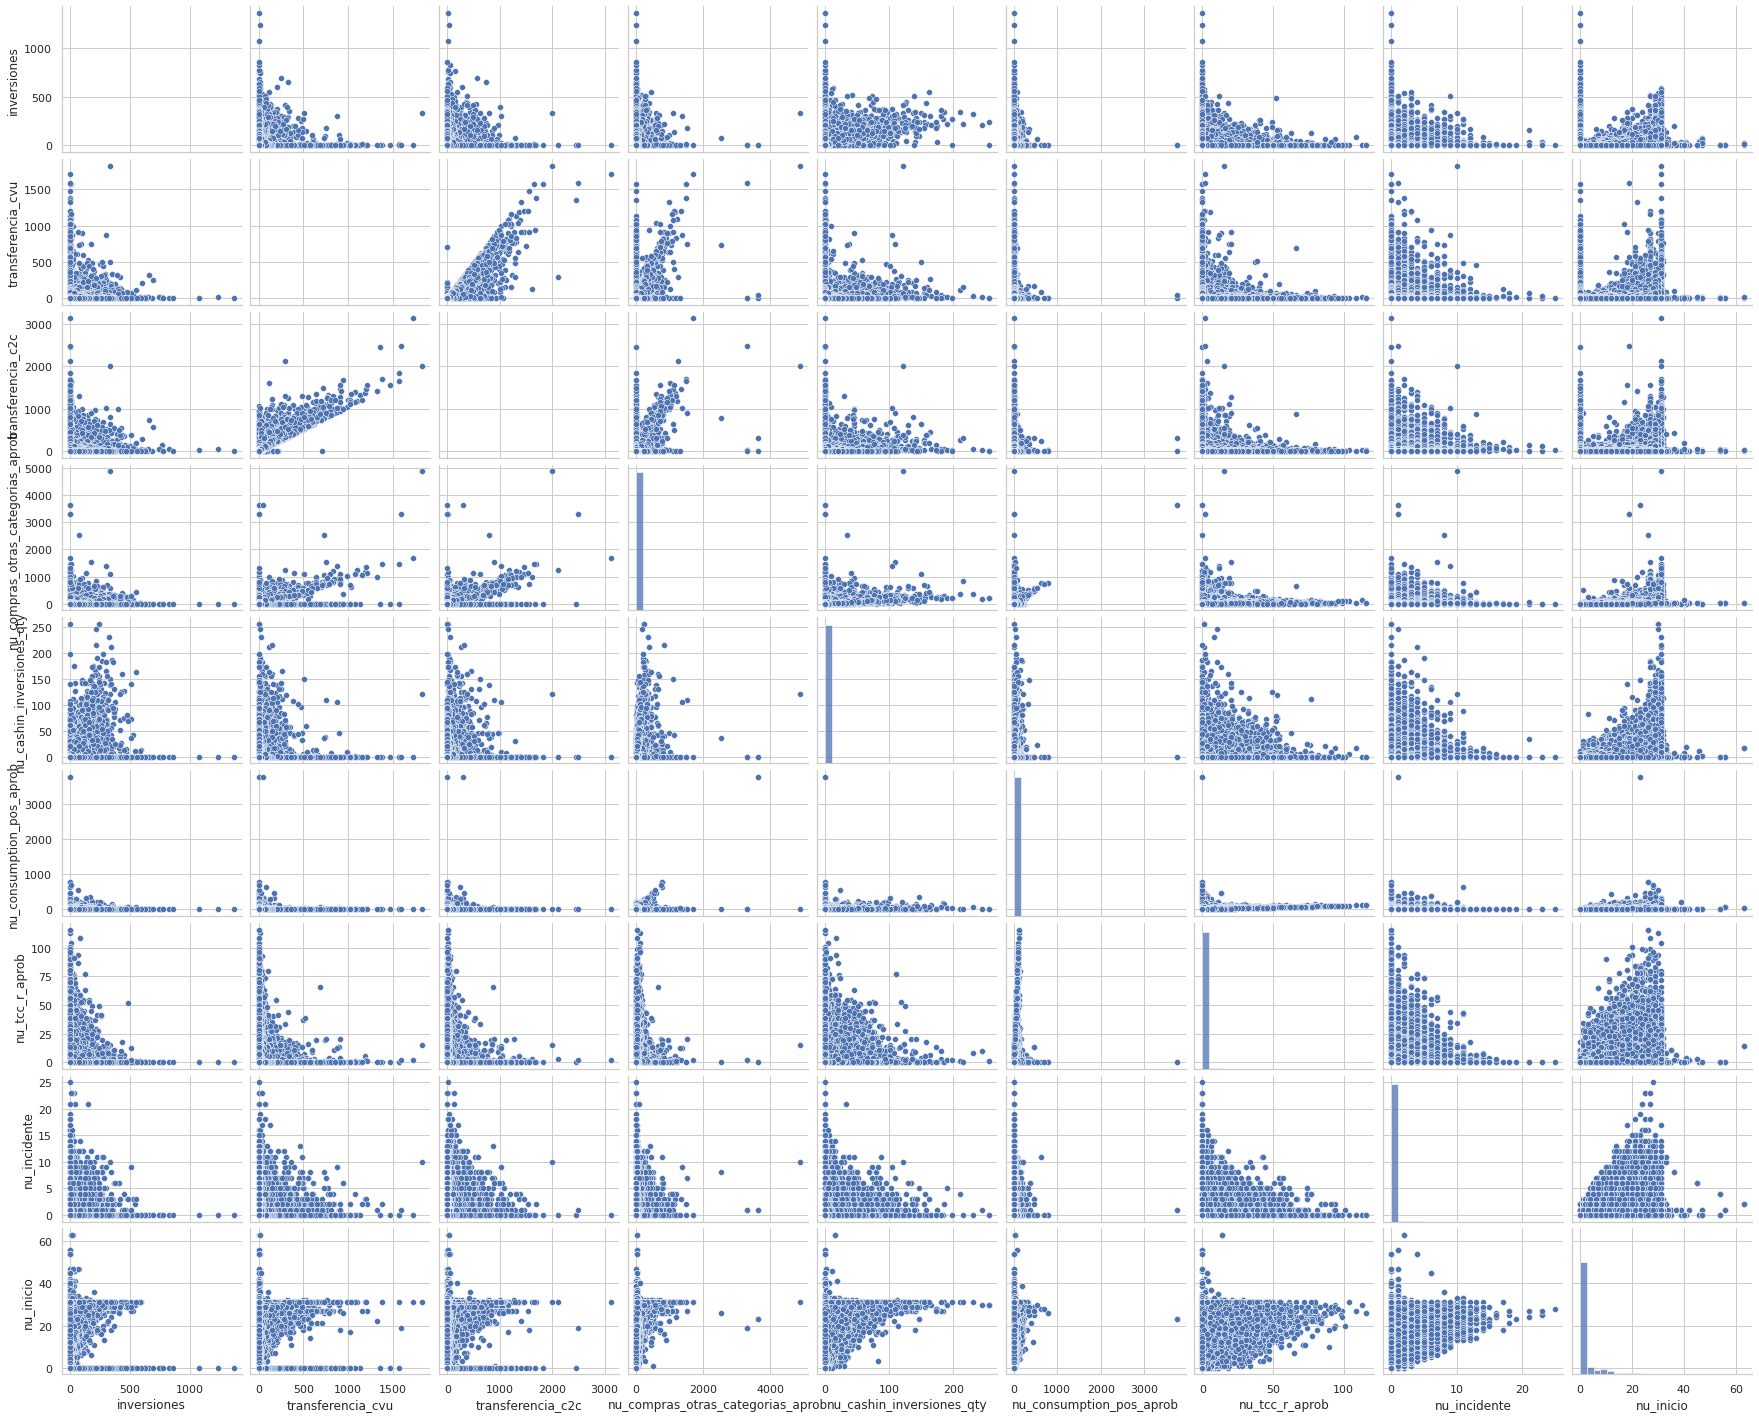

In [67]:
g=sns.pairplot(
    temp,
    x_vars=["inversiones", "transferencia_cvu", "transferencia_c2c", "nu_compras_otras_categorias_aprob", 
"nu_cashin_inversiones_qty", "nu_consumption_pos_aprob", "nu_tcc_r_aprob", "nu_incidente", "nu_inicio"],
    y_vars=["inversiones", "transferencia_cvu", "transferencia_c2c", "nu_compras_otras_categorias_aprob", 
"nu_cashin_inversiones_qty", "nu_consumption_pos_aprob", "nu_tcc_r_aprob", "nu_incidente", "nu_inicio"]
)
g.fig.set_figheight(20)
g.fig.set_figwidth(25)
plt.show()

The linear relationship of the following variables is graphically confirmed:

* transferencia_cvu with nu_compras_otras_categ
* nu_inicio with cahin_inv
* nu_inicio with tcc_r_aprob
* transferencia_cvu with transferencia_c2c

# 2. EDA Rules [Apriori](http://www.vldb.org/conf/1994/P487.PDF)

In order to understand cross-selling within Ualá's products, an algorithm of Association Rules (Apriori) is run to measure the frequency of use of the product basket offered by the company.

Demographic/Categorical features that we do not want to have within the array are eliminated. Futhermore, to prioritize the most recent transactionality of the users, the last month available in the dataset is analyzed:

In [ ]:
df_=df[df['periodo']=='2021-03'].copy()
a = df_.columns.isin(['year_month','os_name','external_id','periodo','fecha_alta','provincia','sexo','fecha_nacimiento','zona','edad'])
a_comple = df_.columns[~a]

df_ = df_.loc[:,a_comple]

In [25]:
data_pivot = pd.melt(df_, 
                     id_vars='account_id', 
                     var_name='producto', 
                     value_name='value')

In [26]:
data_pivot = data_pivot[data_pivot.value > 0]

In [ ]:
data_matriz = (data_pivot
               .groupby(['account_id', 'producto'])['value']
               .sum().unstack().reset_index().fillna(0)
               .set_index('account_id'))

In [29]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

data_matriz = data_matriz.applymap(encode_units)

Transactions related to the products of interest (Products the stakeholders want to recommend) are selected below to recommend:

In [31]:
data_matriz_test = data_matriz[[
 'nu_cashin_prestamos_qty',
 'nu_cashin_adquirencia_qty',
 'nu_investments_deposit_aprob',
 'nu_telerecargas_carga_aprob',
 'nu_compras_otras_categorias_aprob',
 'nu_compras_aprob',
 'nu_entretenimiento_aprob',
 'nu_servicios_débitos_automaticos_aprob',
 'nu_supermercados_alimentos_aprob']]

In [ ]:
data_matriz_test= data_matriz

In [50]:
itemsets = apriori(data_matriz_test, min_support=0.01, use_colnames=True)

In [51]:
rules = association_rules(itemsets, metric="lift", min_threshold=1)

In [52]:
itemsets

,support,itemsets
0,0.060448,(nu_investments_deposit_aprob)
1,0.070819,(nu_telerecargas_carga_aprob)
2,0.200978,(nu_compras_otras_categorias_aprob)
3,0.030897,(nu_compras_aprob)
4,0.039618,(nu_entretenimiento_aprob)
5,0.094297,(nu_servicios_débitos_automaticos_aprob)
6,0.033479,(nu_supermercados_alimentos_aprob)
7,0.017849,"(nu_investments_deposit_aprob, nu_telerecargas..."
8,0.060448,"(nu_compras_otras_categorias_aprob, nu_investm..."
9,0.025867,"(nu_servicios_débitos_automaticos_aprob, nu_in..."


In [53]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(nu_investments_deposit_aprob),(nu_telerecargas_carga_aprob),0.060448,0.070819,0.017849,0.295274,4.169399,0.013568,1.318499
1,(nu_telerecargas_carga_aprob),(nu_investments_deposit_aprob),0.070819,0.060448,0.017849,0.252033,4.169399,0.013568,1.256141
2,(nu_compras_otras_categorias_aprob),(nu_investments_deposit_aprob),0.200978,0.060448,0.060448,0.300771,4.975680,0.048300,1.343697
3,(nu_investments_deposit_aprob),(nu_compras_otras_categorias_aprob),0.060448,0.200978,0.060448,1.000000,4.975680,0.048300,inf
4,(nu_servicios_débitos_automaticos_aprob),(nu_investments_deposit_aprob),0.094297,0.060448,0.025867,0.274315,4.538003,0.020167,1.294709
5,(nu_investments_deposit_aprob),(nu_servicios_débitos_automaticos_aprob),0.060448,0.094297,0.025867,0.427919,4.538003,0.020167,1.583174
6,(nu_compras_otras_categorias_aprob),(nu_telerecargas_carga_aprob),0.200978,0.070819,0.070819,0.352374,4.975680,0.056586,1.434750
7,(nu_telerecargas_carga_aprob),(nu_compras_otras_categorias_aprob),0.070819,0.200978,0.070819,1.000000,4.975680,0.056586,inf
8,(nu_compras_aprob),(nu_telerecargas_carga_aprob),0.030897,0.070819,0.011404,0.369094,5.211765,0.009216,1.472772
9,(nu_telerecargas_carga_aprob),(nu_compras_aprob),0.070819,0.030897,0.011404,0.161027,5.211765,0.009216,1.155106


It is observed that savings product is the most present in cross-selling within the product basket, both in the role of antecedent and consequent. This can be useful as a baseline to evaluate future models to be applied, and to think about the users population to be analyzed.